In [1]:
import glob
import os


import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

import transport


In [2]:
lon_min=-58
lat_min=50
lon_max=-55
lat_max=52

In [3]:
data_dir='/ocean/handres/glorys12/'
mask = xr.open_dataset(os.path.join(data_dir,'statics_subset_mask_bathy.nc'))
mask = mask.sel(latitude=slice(lat_min, lat_max),
                longitude=slice(lon_min, lon_max))
coords = xr.open_dataset(os.path.join(data_dir,'statics_subset_coordinates.nc'))
coords = coords.sel(latitude=slice(lat_min, lat_max),
                    longitude=slice(lon_min, lon_max))

In [4]:
transects = pd.read_csv('../../data/sections_info.txt', delim_whitespace=True,
                       names=['Shortname', 'Longname', 'lon1', 'lat1', 'lon2', 'lat2', 'Dir-E', 'Dir-N'],
                       header=0)

In [5]:
belle = transects[transects.Shortname=='SBI']

# 2002-2003
Compare with Smith et al 2006

Note: Smith el al used the convetion that negative transport means flow into the Gulf. I used the convention positive transport means flow into the Gulf. So below, I'll flip the sign of the transport for easier comparison.

In [6]:
year='[1,2][0-9][0-9][0-9]'
month='[0,1][0-9]'
f = glob.glob(os.path.join(data_dir,f'*_{year}_daily{month}.nc'))
d = xr.open_mfdataset(f)
dsel = d.sel(time=slice('2002-11-01', '2003-06-01'),
             latitude=slice(lat_min, lat_max),
             longitude=slice(lon_min, lon_max))

In [7]:
tbar, along_bar, across_bar = transport.get_transect_transport(dsel.uo, dsel.vo, 
                                                    mask.mask, coords.e3t,
                                                    belle
                                                    )

In [8]:
tfull, along, across = transport.get_transect_transport(dsel.uo, dsel.vo, 
                                                    mask.mask, coords.e3t,
                                                    belle, barotropic=False
                                                    )

In [9]:
tbar

<xarray.DataArray (time: 213)>
dask.array<add, shape=(213,), dtype=float64, chunksize=(31,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2002-11-01T12:00:00 ... 2003-06-01T12:00:00
    longitude  float64 -56.25
    latitude   float64 51.91
    depth      float32 0.494
Attributes:
    units:       m^3/s
    short_name:  transport
    long_name:   Volume Transport

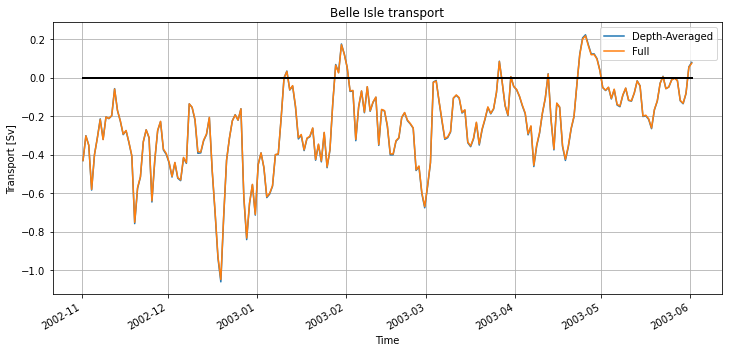

In [10]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
(-tbar/1e6).plot(ax=ax, label='Depth-Averaged')
(-tfull/1e6).plot(ax=ax, label='Full')
ax.set_title('Belle Isle transport')
ax.set_ylabel('Transport [Sv]')
ax.set_xlabel('Time')
ax.grid()
ax.legend()
ax.plot([tbar.time.values[0],tbar.time.values[-1]], [0,0], 'k-', lw=2)

Figure below from Smith et al 2006

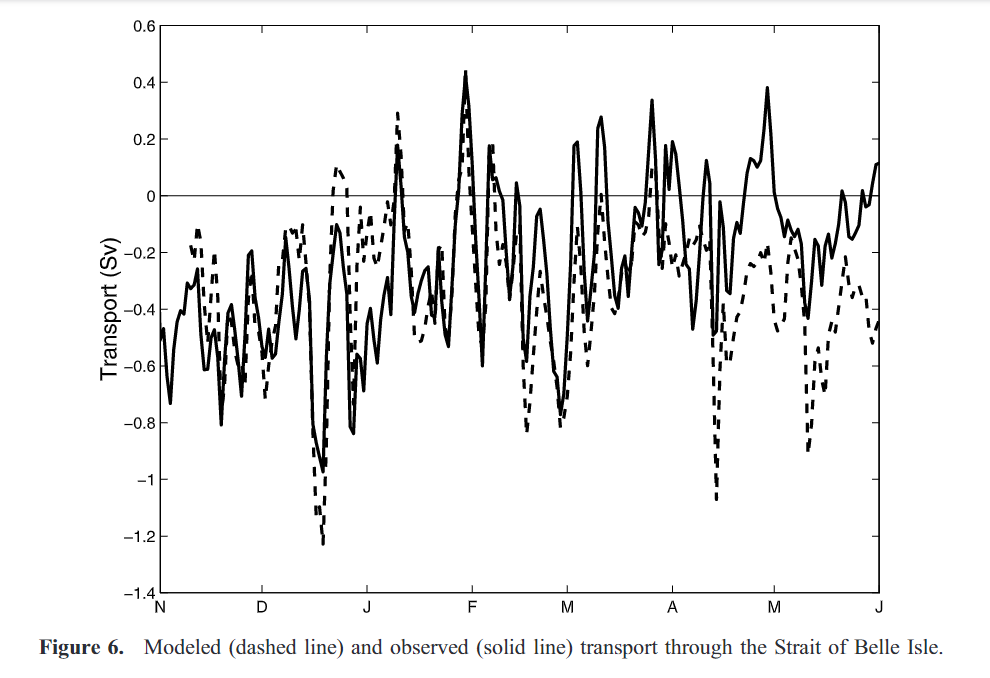

In [11]:
from IPython.display import Image
Image('smith-transport-belleisle.PNG')

Smith et all reports means over a few time periods:
* Winter (Dec 1, 2002 to April 3, 2003) = 0.28 Sv into Gulf
* Fall mean = 0.5 Sv into Gulf (extact time period not defined... and given the fall isn't fully covered I'll assume Nov 1, 2002 to Nov 30, 2002).

Reproduce with GLORYS12

In [12]:
winter = (tbar.sel(time=slice('2002-12-01', '2003-04-03')).mean())/1e6
winter.values

array(0.28931182)

So GLORYS is a good match in winter. Smith also points out that the 0.28Sv is lower than other estimates of winter transort (perhaps there is a bias in their methods - Smith used one mooring in the centre of the channel and neglected any lateral shear. Also assumed cross sectional area of 1e6m^2.). IDEA: Look at those other papers and perhaps compute a seasonal climatolgy for transport. 


In [13]:
fall = (tbar.sel(time=slice('2002-11-01', '2002-11-30')).mean())/1e6
fall.values

array(0.34739801)

What if I used a representative value at the centre of the transect and the same cross-sectional area as Smith et al?

In [14]:
i=45
single=across_bar.isel(transect=i)
tsingle = single*1e6

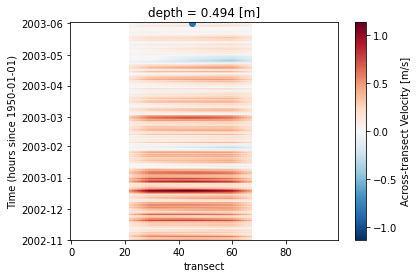

In [15]:
fig, ax = plt.subplots(1,1)
across_bar.plot(ax=ax)
ax.plot(i, across_bar.time.max(), 'o')

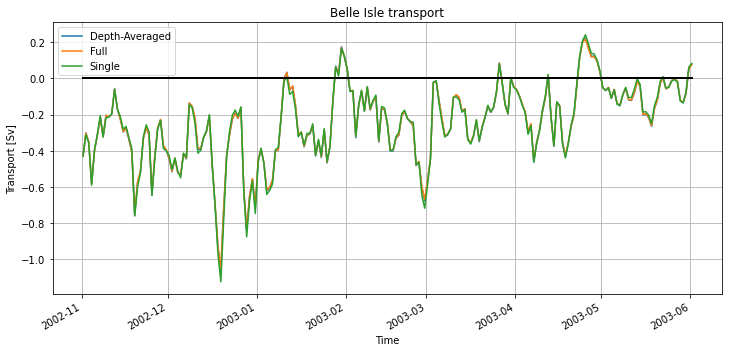

In [16]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
(-tbar/1e6).plot(ax=ax, label='Depth-Averaged')
(-tfull/1e6).plot(ax=ax, label='Full')
(-tsingle/1e6).plot(ax=ax, label='Single')
ax.set_title('Belle Isle transport')
ax.set_ylabel('Transport [Sv]')
ax.set_xlabel('Time')
ax.grid()
ax.legend()
ax.plot([tbar.time.values[0],tbar.time.values[-1]], [0,0], 'k-', lw=2)

In [17]:
winter = (tsingle.sel(time=slice('2002-12-01', '2003-04-03')).mean())/1e6
winter.values

array(0.29158944, dtype=float32)

In [18]:
fall = (tsingle.sel(time=slice('2002-11-01', '2002-11-30')).mean())/1e6
fall.values

array(0.34704834, dtype=float32)

The single data point at channel centre gives consistent results compared to depth-averaged and full currents. So I trust the comparison with Smith. 

# Annual means
Using the `*_YYYY_daily_annclim.nc` files from Heather

In [19]:
year='[1,2][0-9][0-9][0-9]'
f = glob.glob(os.path.join(data_dir,f'*_{year}_daily_annmean.nc'))
dyear = xr.open_mfdataset(f)
dyear = dyear.sel(latitude=slice(lat_min, lat_max),
                  longitude=slice(lon_min, lon_max))
dyear

<xarray.Dataset>
Dimensions:    (time: 27, bnds: 2, longitude: 37, latitude: 25, depth: 50)
Coordinates:
  * time       (time) datetime64[ns] 1993-07-02T12:00:00 ... 2019-07-02T12:00:00
  * longitude  (longitude) float32 -58.0 -57.92 -57.83 ... -55.17 -55.08 -55.0
  * latitude   (latitude) float32 50.0 50.08 50.17 50.25 ... 51.83 51.92 52.0
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    bottomT    (time, latitude, longitude) float32 dask.array<chunksize=(1, 25, 37), meta=np.ndarray>
    sithick    (time, latitude, longitude) float32 dask.array<chunksize=(1, 25, 37), meta=np.ndarray>
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(1, 25, 37), meta=np.ndarray>
    thetao     (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 25, 37), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 25, 37), meta=np.ndarray>
    uo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 25, 37), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 25, 37), meta=np.ndarray>
Attributes: (12/29)
    CDI:                       Climate Data Interface version 2.0.3 (https://...
    Conventions:               CF-1.4
    source:                    MERCATOR GLORYS12V1
    institution:               MERCATOR OCEAN
    title:                     daily mean fields from Global Ocean Physics An...
    easting:                   longitude
    ...                        ...
    z_min:                     0.494025
    z_max:                     5727.917
    NCO:                       4.7.2
    nco_openmp_thread_number:  1
    frequency:                 year
    CDO:                       Climate Data Operators version 2.0.3 (https://...

In [20]:
dyear.time

<xarray.DataArray 'time' (time: 27)>
array(['1993-07-02T12:00:00.000000000', '1994-07-02T12:00:00.000000000',
       '1995-07-02T12:00:00.000000000', '1996-07-02T00:00:00.000000000',
       '1997-07-02T12:00:00.000000000', '1998-07-02T12:00:00.000000000',
       '1999-07-02T12:00:00.000000000', '2000-07-02T00:00:00.000000000',
       '2001-07-02T12:00:00.000000000', '2002-07-02T12:00:00.000000000',
       '2003-07-02T12:00:00.000000000', '2004-07-02T00:00:00.000000000',
       '2005-07-02T12:00:00.000000000', '2006-07-02T12:00:00.000000000',
       '2007-07-02T12:00:00.000000000', '2008-07-02T00:00:00.000000000',
       '2009-07-02T12:00:00.000000000', '2010-07-02T12:00:00.000000000',
       '2011-07-02T12:00:00.000000000', '2012-07-02T00:00:00.000000000',
       '2013-07-02T12:00:00.000000000', '2014-07-02T12:00:00.000000000',
       '2015-07-02T12:00:00.000000000', '2016-07-02T00:00:00.000000000',
       '2017-07-02T12:00:00.000000000', '2018-06-29T12:00:00.000000000',
       '2019-07-02T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-07-02T12:00:00 ... 2019-07-02T12:00:00
Attributes:
    standard_name:  time
    long_name:      Time (hours since 1950-01-01)
    bounds:         time_bnds
    axis:           T

In [21]:
tyear, along, across = transport.get_transect_transport(dyear.uo, dyear.vo, 
                                                        mask.mask, coords.e3t, belle,
                                                        )

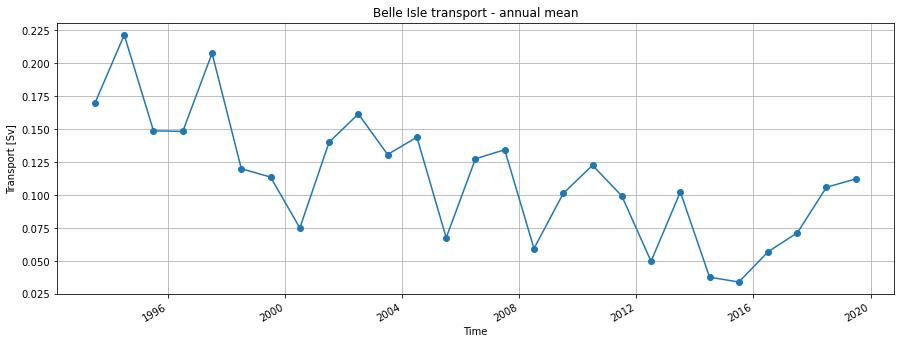

In [22]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
(tyear/1e6).plot(marker='o', ls='-', ax=ax)
ax.set_title('Belle Isle transport - annual mean')
ax.set_ylabel('Transport [Sv]')
ax.set_xlabel('Time')
ax.grid()

Trend and values are consistent with Nicolas Lambert's calculations in the Model State of the Ocean Report 

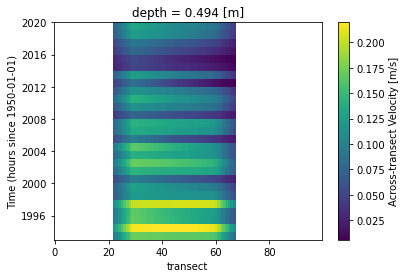

In [23]:
import numpy as np
across.plot()

# Next steps

We wanted to look at transport through the Strait of Belle Isle because we were worried that water wasn't going in the right place. But given these comparisons, I'm not sure any discrepancies through Belle Isle are going to be a major problem on the NL Shelf (as for the Gulf, that is another question). The transports through Belle Isle are much smaller than in other transects. Plus, I'm actually quite surprised with th match between GLORYS and the Smith data, although GLORYS transports are lower. I know I'm only comparing plots, plus a winter average, but the trends and magnitudes are acutally quite good.

For next steps we could:
* Look for more data
* Talk to Greg and Francois about their work

It would also be nice to look at transports away from Belle Isle. I think I'll go there next...


# Full current vs depth-averaged for computing transect

In [24]:
tyearfull, along, across = transport.get_transect_transport(dyear.uo, dyear.vo, 
                                         mask.mask, coords.e3t, belle,
                                         barotropic=False)

(100.0, 0.0)

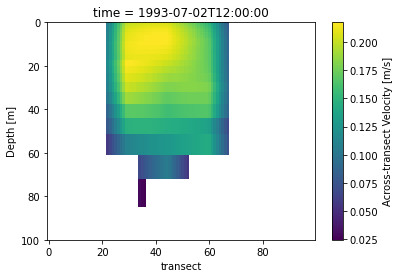

In [25]:
fig,ax=plt.subplots(1,1)
across.isel(time=0).plot(ax=ax)
ax.set_ylim([100,0])

(100.0, 0.0)

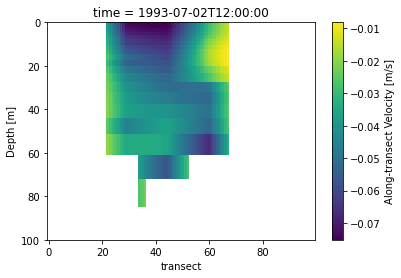

In [26]:
fig,ax=plt.subplots(1,1)
along.isel(time=0).plot(ax=ax)
ax.set_ylim([100,0])

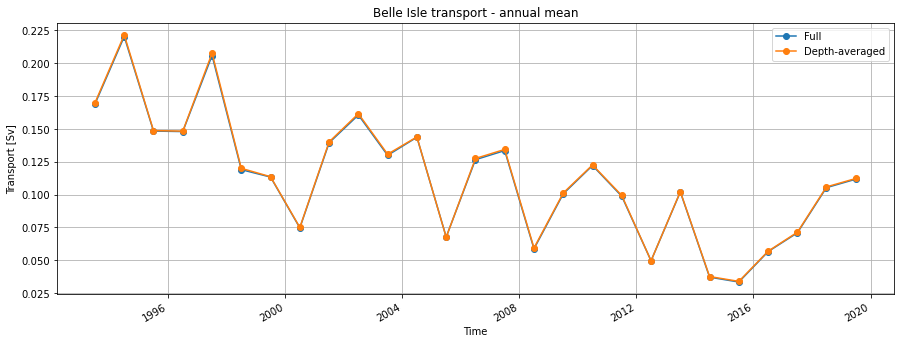

In [27]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
(tyearfull/1e6).plot(marker='o', ls='-', ax=ax,label='Full')
(tyear/1e6).plot(marker='o', ls='-', ax=ax,label='Depth-averaged')
ax.set_title('Belle Isle transport - annual mean')
ax.set_ylabel('Transport [Sv]')
ax.set_xlabel('Time')
ax.grid()
ax.legend()

# Does number of points impact calculation?

In [28]:
tyear200, along, across = transport.get_transect_transport(dyear.uo, dyear.vo, 
                                         mask.mask, coords.e3t, belle,
                                         num_points=200)
tyear500, along, across = transport.get_transect_transport(dyear.uo, dyear.vo, 
                                         mask.mask, coords.e3t, belle,
                                         num_points=500)
tyear50, along, across = transport.get_transect_transport(dyear.uo, dyear.vo, 
                                         mask.mask, coords.e3t,belle,
                                         num_points=50)
tyear20, along, across = transport.get_transect_transport(dyear.uo, dyear.vo, 
                                         mask.mask, coords.e3t,  belle,
                                         num_points=20)

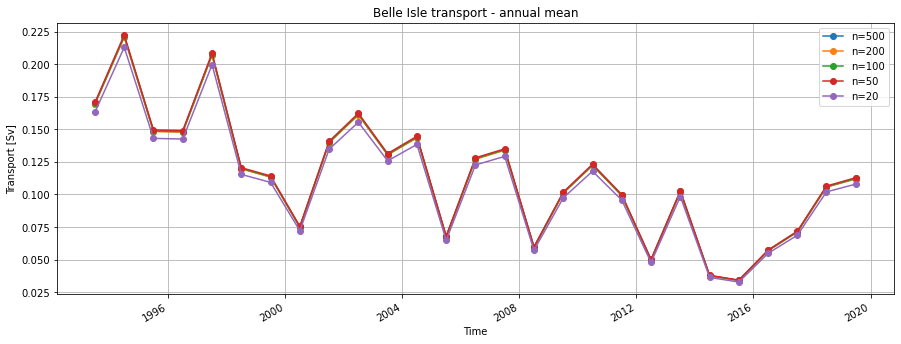

In [29]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
(tyear500/1e6).plot(marker='o', ls='-', ax=ax,label='n=500')
(tyear200/1e6).plot(marker='o', ls='-', ax=ax,label='n=200')
(tyear/1e6).plot(marker='o', ls='-', ax=ax,label='n=100')
(tyear50/1e6).plot(marker='o', ls='-', ax=ax,label='n=50')
(tyear20/1e6).plot(marker='o', ls='-', ax=ax,label='n=20')
ax.set_title('Belle Isle transport - annual mean')
ax.set_ylabel('Transport [Sv]')
ax.set_xlabel('Time')
ax.grid()
ax.legend()